Look at ONC patrol data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime
import netCDF4 as nc
import seaborn as sns
import glob

import ONC

from salishsea_tools import tidetools, viz_tools
from nowcast import figures
import comparisons

%matplotlib inline

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_color_codes()

In [3]:
NOWCAST_PATH = '/results/SalishSea/nowcast/'

In [4]:
def find_data_line(csvfilename):
    """ Look up line number where data beings in csvfilename.
    Assumes first line without # in the front is the data
    
    :arg csvfilename: name of file
    :type csvfilename: string
    
    :returns: data_line, the line number of the data.
    """
    l = open(csvfilename, 'r')

    for i, line in enumerate(l):
        if "#" not in line:
            data_line = i
            break
    l.close()
    
    return data_line

In [5]:
def find_column_names(csvfilename, data_line):
    """Find the columns in an ONC csv file.
    Assumes column names are the line before two lines before data_line
    
    :arg csvfilename: name of file
    :type csvfilename: string
    
    :arg data_line: line number where the data begins
    :type data_lins: nonnegative integer
    
    :returns: columns
    line number of data start and list of column names
    """
    columns = pd.read_csv(csvfilename, skiprows=data_line-2, nrows=1,
                          header=None, skipinitialspace=True, dtype=str)
    columns = np.array(columns)[0]
    columns[0] = columns[0].replace('#', '')
    columns[0] = columns[0].replace('"', '')
    
    return columns


In [6]:
def load_patrol_csv(csvfilename):
    """Loads data contained in ONC patrol csv.
    
    :arg csvfilename: name of file
    :type csvfilename: string
    
    :returns: data, a pandas dataframe
    """
    
    data_line = find_data_line(csvfilename)
    columns = find_column_names(csvfilename, data_line)
    data = pd.read_csv(csvfilename, header=None, skiprows=data_line,
                       names=columns, parse_dates=[0], low_memory=False)
    data = data.convert_objects(convert_numeric=True)
    data.rename(columns={'Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)': 'time'},
                inplace=True)
    data['day'] = [datetime.datetime(d.year, d.month, d.day) for d in data.time]
    return data

In [7]:
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

In [8]:
csvfile = "/ocean/nsoontie/MEOPAR/ONC/Patrols/Victoria_Patrol9_CTD_20150220T182104Z_20151001T195734Z-Corrected.csv"
data_line = find_data_line(csvfile)
print(data_line)
columns = find_column_names(csvfile, data_line)
print(columns)
data=load_patrol_csv(csvfile)


59
['Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)'
 'Absolute Pressure Corrected (decibar)'
 'Absolute Pressure Corrected QC Flag  ' 'Conductivity Corrected (S/m)'
 'Conductivity Corrected QC Flag  ' 'Density Corrected (kg/m3)'
 'Density Corrected QC Flag  ' 'Depth Corrected (m)'
 'Depth Corrected QC Flag  ' 'Practical Salinity Corrected (psu)'
 'Practical Salinity Corrected QC Flag  ' 'Pressure Corrected (decibar)'
 'Pressure Corrected QC Flag  ' 'Sound Speed Corrected (m/s)'
 'Sound Speed Corrected QC Flag  ' 'Temperature Corrected (C)'
 'Temperature Corrected QC Flag  ' 'Latitude Corrected (deg)'
 'Latitude Corrected QC Flag  ' 'Longitude Corrected (deg)'
 'Longitude Corrected QC Flag  ']


In [9]:
def exclude_bad(data, columns, values):
    data_return=data
    for col in columns:
        for val in values:
            data_return=data_return[data_return[col] != val]
    return data_return

In [10]:
data = exclude_bad(data,['Practical Salinity Corrected QC Flag  '], [0,4,9])

In [11]:
data[data['Temperature Corrected QC Flag  '] ==9]

,time,Absolute Pressure Corrected (decibar),Absolute Pressure Corrected QC Flag,Conductivity Corrected (S/m),Conductivity Corrected QC Flag,Density Corrected (kg/m3),Density Corrected QC Flag,Depth Corrected (m),Depth Corrected QC Flag,Practical Salinity Corrected (psu),...,Pressure Corrected QC Flag,Sound Speed Corrected (m/s),Sound Speed Corrected QC Flag,Temperature Corrected (C),Temperature Corrected QC Flag,Latitude Corrected (deg),Latitude Corrected QC Flag,Longitude Corrected (deg),Longitude Corrected QC Flag,day


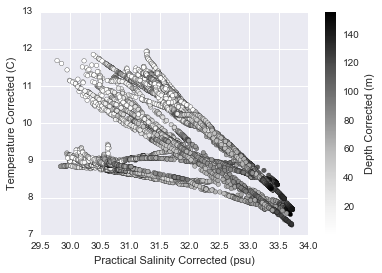

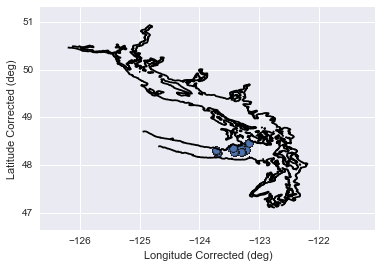

In [12]:
fig,ax=plt.subplots(1,1)
data.plot(x='Practical Salinity Corrected (psu)', y='Temperature Corrected (C)',
          c='Depth Corrected (m)',kind='scatter',ax=ax)
fig,ax=plt.subplots(1,1)
data.plot(x='Longitude Corrected (deg)', y='Latitude Corrected (deg)',
                 kind='scatter',ax=ax,s=50)
viz_tools.plot_coastline(ax,grid_B,coords='map')

### Isolate a day

In [14]:
def list_days(data):
    """List the days in the database
    
    :arg data: the database. data is expected to have a column called day with datetimes Y-M-D
    :type data: pandas dataframe
    
    :returns: data_days, days
    data_days is a grouped dataframe, grouped by the day
    days is a list of the days in data
    """
    data_days = data.groupby(data.day)
    days= list(data_days.groups.keys())
    return data_days, days

In [15]:
data_days, days = list_days(data)
day =data_days.get_group(days[2]).dropna()
print(day.time.min())
print(day[0:1])

2015-08-06 14:46:19.167000
                        time  Absolute Pressure Corrected (decibar)  \
9099 2015-08-06 14:46:19.167                              11.947367   

      Absolute Pressure Corrected QC Flag    Conductivity Corrected (S/m)  \
9099                                      7                        3.5106   

      Conductivity Corrected QC Flag    Density Corrected (kg/m3)  \
9099                                 7                1023.147955   

      Density Corrected QC Flag    Depth Corrected (m)  \
9099                            7                  1.5   

      Depth Corrected QC Flag    Practical Salinity Corrected (psu)  \
9099                          7                           30.491777   

        ...      Pressure Corrected QC Flag    Sound Speed Corrected (m/s)  \
9099    ...                                 7                  1490.523652   

      Sound Speed Corrected QC Flag    Temperature Corrected (C)  \
9099                                7              

In [16]:
def results_dataset(period, grid, date):
    
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_{}_{}_{}_{}.nc'.format(period,datestr,datestr,grid)
    return nc.Dataset(os.path.join(NOWCAST_PATH,sub_dir,fname))

In [78]:
def retrieve_nowcast_data(var, date, lon, lat,depth, grid_B, mesh_mask):
    """Retrieve nowcast daily mean, min and max of var on date at lon, lat 
    and interpolated to depth.
    
    """
    # look up grid point
    bathy, lons, lats = tidetools.get_bathy_data(grid_B)
    j,i=tidetools.find_closest_model_point(lon, lat, lons, lats,bathy)
    # loading
    grid_d = results_dataset('1d', 'grid_T', date)
    grid_h = results_dataset('1h', 'grid_T', date)   
    var_d = grid_d.variables[var][0, :, j, i]
    var_h = grid_h.variables[var][:, :, j, i]
    gdep = mesh_mask.variables['gdept'][0, :, j, i]
    # masking
    tmask = mesh_mask.variables['tmask'][:, :, j, i]
    tmask = 1- tmask +np.zeros(var_h.shape) 
    var_d = np.ma.array(var_d,mask=tmask[0,:])
    gdep_mask = np.ma.array(gdep,mask=tmask[0,:])
    var_h = np.ma.array(var_h,mask=tmask)
    # interpolate to depth
    var_d_interp = comparisons.interpolate_depth(var_d[np.ma.nonzero(var_d)],
                                                 gdep_mask[np.ma.nonzero(gdep_mask)],depth)
    #var_d_interp = np.interp(depth,gdep_mask[np.ma.nonzero(gdep_mask)],
    #                         var_d[np.ma.nonzero(var_d)],left=np.nan, right=np.nan)
    var_h_interp = np.zeros(var_h.shape[0])
    for t in np.arange(var_h.shape[0]):
        var_h_interp[t] = comparisons.interpolate_depth(var_h[t,:],gdep,depth)
    # daily max and min
    var_max = np.max(var_h_interp)
    var_min = np.min(var_h_interp)
    
    return var_d_interp, var_max, var_min, j ,i
    

In [79]:
def organize_nowcast_data(day,var,grid_B,mesh_mask):
    """Organize nowcast and observation comaprisons.
    
    :type day: groupdyBy pandas dataframe
    
    """  
    
    depths=[]
    model_dailys=[]
    model_maxs=[]
    model_mins=[]
    obs_values=[]
    lons=[]
    lats=[]
    iss=[]
    jss=[]
    
    if var=='vosaline':
        var_obs='Practical Salinity Corrected (psu)'
    elif var=='votemper':
        var_obs='Temperature Corrected (C)'

    date = day.time.min()

    for index, row in day.iterrows():
        lon, lat = row['Longitude Corrected (deg)'], row['Latitude Corrected (deg)']
        depth = row['Depth Corrected (m)']
        obs = row[var_obs]
        
        #model
        try:
            daily, mmax, mmin, j, i = retrieve_nowcast_data(var, date, lon, lat,depth, grid_B, mesh_mask)
        
            lons.append(lon)
            lats.append(lat)
            depths.append(depth)
            obs_values.append(obs)
            model_dailys.append(daily)
            model_maxs.append(mmax)
            model_mins.append(mmin)
            iss.append(i)
            jss.append(j)
        except IndexError:
            print('{},{} grid point not found'.format(lon,lat))
    
    compare = pd.DataFrame({'Depth (m)': depths,
                            'Longitude': lons,
                            'Latitude': lats,
                             var_obs: obs_values,
                            'Model daily average': model_dailys,
                            'Model daily max': model_maxs,
                            'Model daily min':model_mins,
                            'i': iss,
                            'j': jss,})
    
    return compare

In [80]:
compare = organize_nowcast_data(day,'vosaline', grid_B, mesh_mask)

-123.235826,48.322096 grid point not found
-123.23581999999999,48.322103999999996 grid point not found
-123.23581499999999,48.322111 grid point not found
-123.235809,48.322119 grid point not found
-123.235801,48.322129 grid point not found
-123.235794,48.322139 grid point not found
-123.23578700000002,48.322148 grid point not found
-123.23578,48.322157000000004 grid point not found
-123.23577399999999,48.322165000000005 grid point not found
-123.235766,48.322176 grid point not found
-123.235759,48.322185 grid point not found
-123.235753,48.322193 grid point not found
-123.23574599999999,48.322203 grid point not found
-123.23573799999998,48.322213 grid point not found
-123.235731,48.322222 grid point not found
-123.235725,48.322231 grid point not found
-123.23571799999999,48.32224 grid point not found
-123.235712,48.322249 grid point not found
-123.235704,48.322259 grid point not found
-123.23569599999999,48.322269 grid point not found
-123.235689,48.322278000000004 grid point not found

(48, 49)

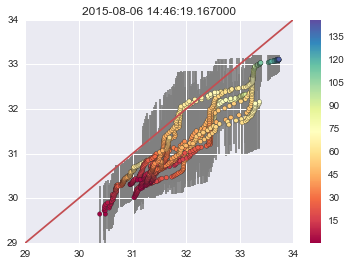

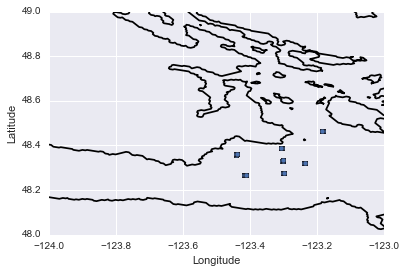

In [81]:
fig,ax=plt.subplots(1,1)
yerr= [compare['Model daily average']-compare['Model daily min'],
      compare['Model daily max']-compare['Model daily average']]
ax.errorbar(compare['Practical Salinity Corrected (psu)'], compare['Model daily average'],yerr=yerr,fmt='none',
           ecolor='gray',marker='',zorder=0)
mesh=ax.scatter(compare['Practical Salinity Corrected (psu)'], compare['Model daily average'],
           c=compare['Depth (m)'],cmap='Spectral')
ax.plot([0,34],[0,34],'r')
ax.set_ylim([29,34])
ax.set_xlim([29,34])
ax.set_title(day.time.min())
plt.colorbar(mesh,ax=ax)

fig,ax=plt.subplots(1,1)
compare.plot(x='Longitude', y='Latitude',kind='scatter',ax=ax)
viz_tools.plot_coastline(ax,grid_B,coords='map')
ax.set_xlim([-124,-123])
ax.set_ylim([48,49])

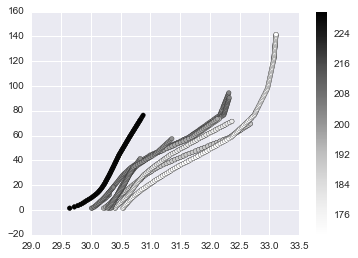

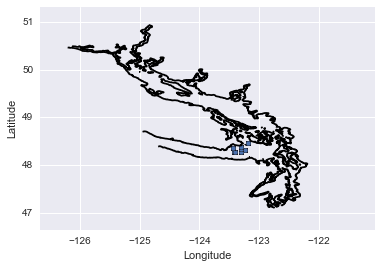

In [82]:
fig,ax=plt.subplots(1,1)
#ax.scatter(compare['Practical Salinity Corrected (psu)'], compare['Depth (m)'],c='b')
mesh=ax.scatter(compare['Model daily average'],compare['Depth (m)'],c=compare['i'])
plt.colorbar(mesh,ax=ax)
fig,ax=plt.subplots(1,1)
compare.plot(x='Longitude', y='Latitude',kind='scatter',ax=ax)
viz_tools.plot_coastline(ax,grid_B,coords='map')

Plan
* If I can isolate a day in this data set, then I can know which nowcast file to open for comparison.
* For each data point in a day, look up model grid location, interpolate to observed depth, then do scatter? error bars can be daily min/max. Plotted value can be daily average.
* It would be nice if I could separate each cast. Perhaps there is some kind of tolerance that I can apply to the lat/lon? 

In [39]:
j1,i1=295,230
j2,i2=271,204
j3,i3=271,205

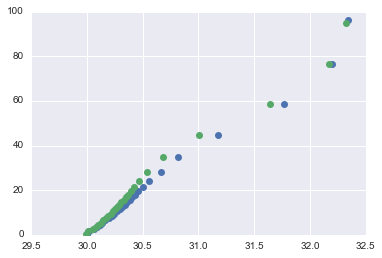

In [40]:
jss = [j2,j3]
iss = [i2,i3]
date=datetime.datetime(2015,8,6)
grid_t = results_dataset('1d','grid_T',date)
for i,j in zip(iss,jss):
    sal1 = grid_t.variables['vosaline'][:][:,:,j,i]
    tmask = 1-mesh_mask.variables['tmask'][:,:,j,i] + np.zeros(sal1.shape)
    sal1=np.ma.array(sal1,mask=tmask)
    deps=mesh_mask.variables['gdept'][0,:,j,i]

    for t in range(sal1.shape[0]):
        plt.plot(sal1[t,:],deps,'o')